In [1]:
#imports

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"# Assign which GPU to run on if using a multi-GPU device

import cupy as cp
import cupyx as cpx
from cupyx.scipy import special
import numpy as np
import numpy.matlib
import scipy as sp
from scipy.stats import norm
from scipy import stats
import matplotlib.pyplot as plt
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"#Unreal data is in .EXR format which may trigger firewalls. This line allows .EXR files to be read correctly
import cv2
from matplotlib.cm import ScalarMappable
import time
from tqdm import tqdm
import random

plt.rcParams['figure.dpi'] = 150#Only for display purposes in JupyterNotebook

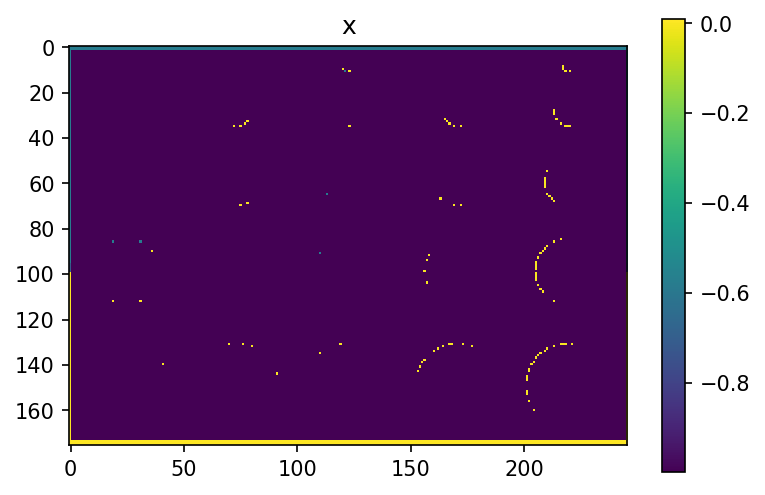

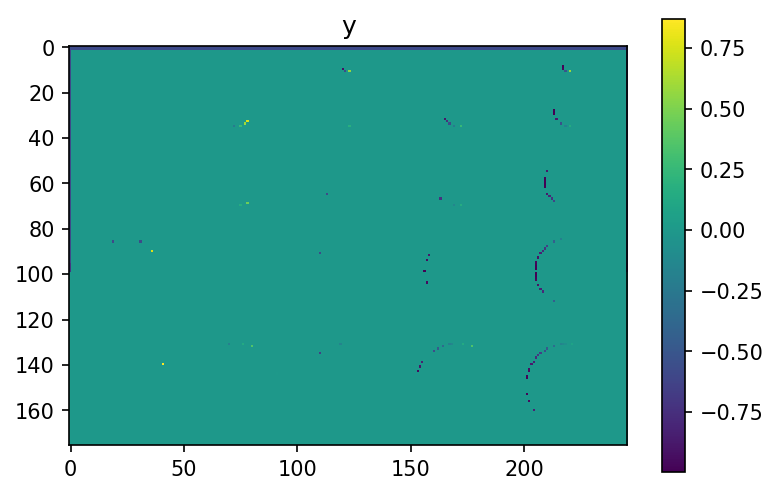

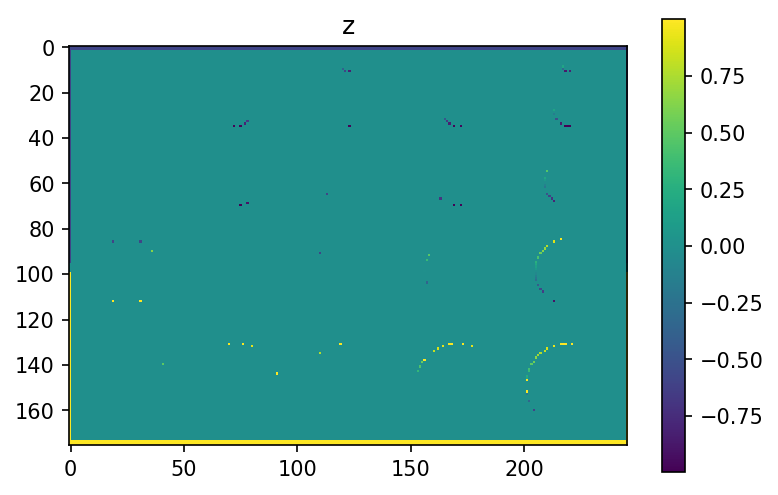

In [2]:
#Reads in the surface normal image from Unreal
normal = cv2.imread("Normal_3_0.EXR",cv2.IMREAD_UNCHANGED)#The UNCHANGED flag ensures the data is not normalised during read in

#print(normal.shape)

normal = cv2.cvtColor(normal[:,:,0:3],cv2.COLOR_BGR2RGB)#Converts the cv2 bgr index to rgb index matching Unreals x,y,z indexing scheme

# Vizulization of surface normal components
plt.imshow(normal[:,:,0],interpolation='none')
plt.colorbar()
plt.title("x")
plt.show()
plt.imshow(normal[:,:,1],interpolation='none')
plt.colorbar()
plt.title("y")
plt.show()
plt.imshow(normal[:,:,2],interpolation='none')
plt.colorbar()
plt.title("z")
plt.show()


(176, 246, 4)


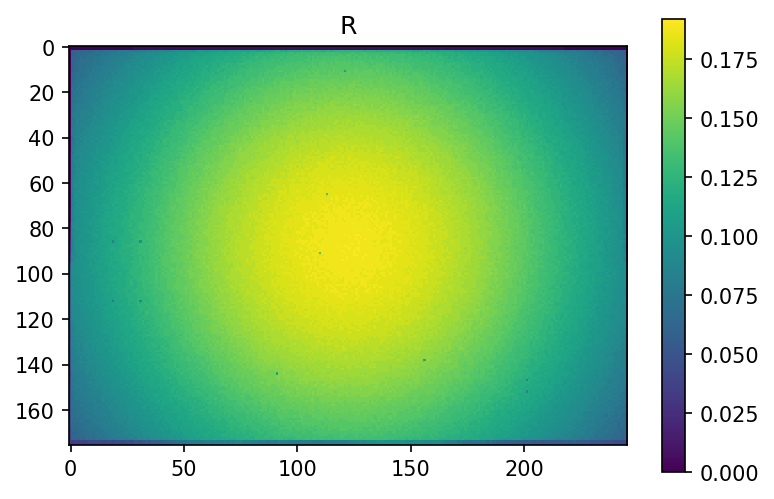

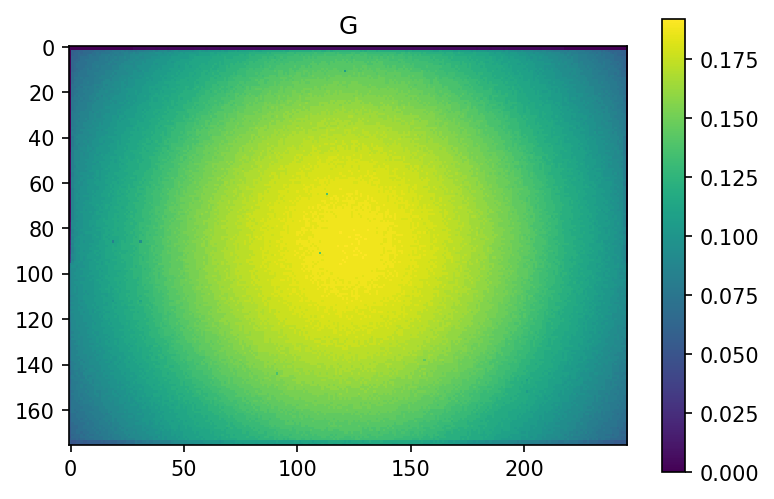

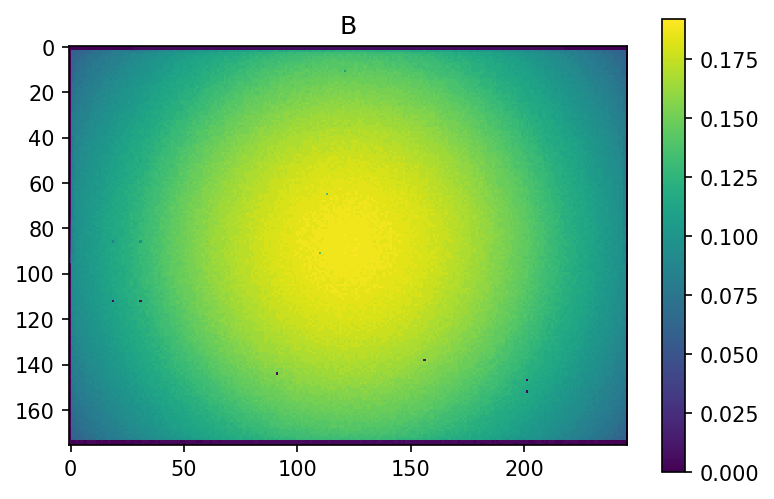

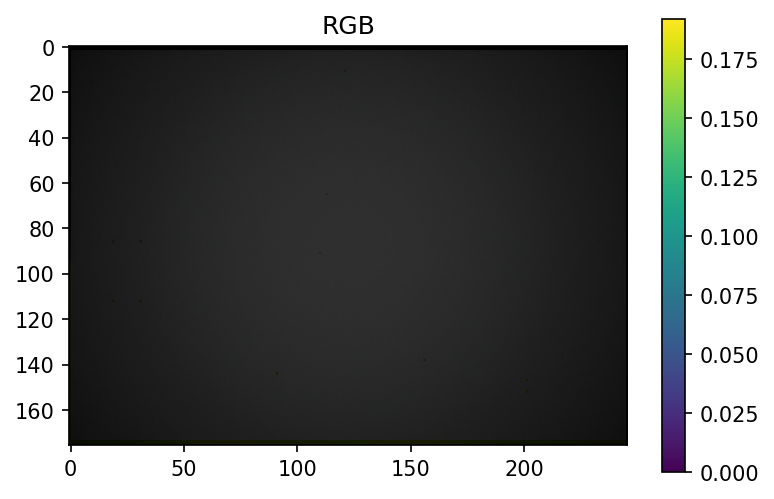

In [3]:
#Reads in base colour image from Unreal which is used for reflectivity calculation
base_c = cv2.imread("Base_Col_3_0.EXR",cv2.IMREAD_UNCHANGED)#The UNCHANGED flag ensures the data is not normalised during read in
print(base_c.shape)

base_c = cv2.cvtColor(base_c[:,:,0:3],cv2.COLOR_BGR2RGB)#Converts the cv2 bgr index to rgb index matching Unreals rgb indexing scheme

# Vizulization of base colour components
plt.imshow(base_c[:,:,0],interpolation='none')
plt.colorbar()
plt.title("R")
plt.show()
plt.imshow(base_c[:,:,1],interpolation='none')
plt.colorbar()
plt.title("G")
plt.show()
plt.imshow(base_c[:,:,2],interpolation='none')
plt.colorbar()
plt.title("B")
plt.show()

plt.imshow(base_c,interpolation='none')
plt.colorbar()
plt.title("RGB")
plt.show()


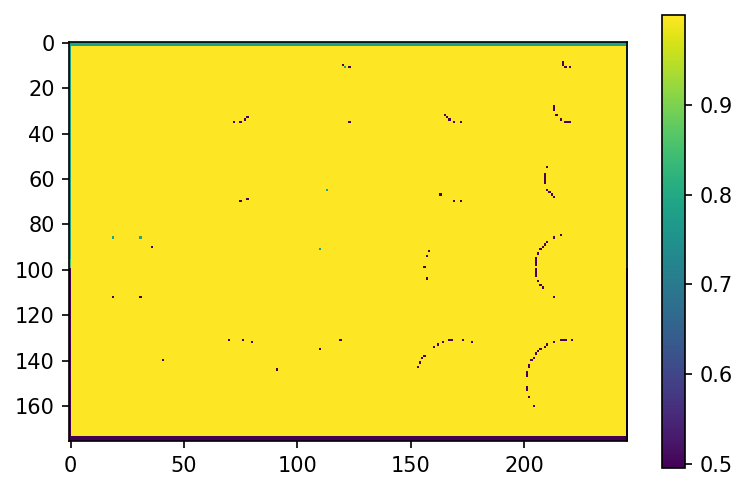

In [4]:
cam_vec = np.asarray([1,0,0])#camera vector (x,y,z) manual input

cam_vec_mag = np.sqrt(np.sum(cam_vec**2))#magnitude of camera forward vector

norm_mag = np.sqrt(np.sum(normal**2,axis=2))#normalized magnitude of camera forward vector

norm_prod = cam_vec_mag*norm_mag#normalized product

#plt.imshow(norm_prod,interpolation='none')
#plt.colorbar()
#plt.show()

dot_p1 = np.sum(cam_vec*normal,axis=2) # The first component of the dot product

#plt.imshow(dot_p1,interpolation='none')
#plt.colorbar()
#plt.show()

#The lambertian scattering angle defined with respect to the surface normal. Divison by 0 exceptions are handeled by the where flag.
lambertian_ang = 1-((np.divide(dot_p1, norm_prod, out=np.zeros_like(dot_p1), where=norm_prod!=0)+1)/2)

plt.imshow(lambertian_ang,interpolation='none')
plt.colorbar()
plt.show()


In [5]:

#Reads in red green blue depth image from Unreal
RGBD = cv2.imread("RGBD_3_0.EXR",cv2.IMREAD_UNCHANGED)#The UNCHANGED flag ensures the data is not normalised during read in

inten = cv2.cvtColor(RGBD[:,:,0:3],cv2.COLOR_BGR2GRAY)#Converts the first three channels of the image to greyscale
depth = RGBD[:,:,3]#Extracts the 4 channel in the image as the ground truth depth

#

#print("depth_min: ",np.amin(depth))
#print("depth_max: ",np.amax(depth))

c_speed = 2.99e8# The speed of light

#plt.imshow(depth,vmin = 1460,vmax = 1700,interpolation='none')
#plt.show()

depth = cv2.medianBlur(depth,3)#Median filters the depth to remove artifacts from Unreal rendering

depth = depth/100.0#Converts Unreal units which are centimeters to meters

peak_pos = (depth/c_speed)#Converts the depth to time

peak_pos = peak_pos - np.amin(peak_pos)#Converts the image to a relative depth



In [6]:
#Initial image size, the y axis has been cropped from 192 to 176 pixels and the x axis has been double to 256 then cropped to 246
img_x = 246
img_y = 176

c1 = np.arange(2,img_x,4)#The columns from 2 to 246 in steps of 4
c2 = c1+1 #The adjacent set of columns

c3 = np.vstack((c1,c2)).reshape((-1,),order='F') #This line arranges sets of pairs of columns to be used as indices

#print(c3)

peak_pos_2 = peak_pos[2:174,c3]#Reduces the rows to the final size and removes half of the columns from the image but does so in two column pairs. This is to match the 2:1 aspect ratio of the pixels on the sensor

peak_pos_2 = (peak_pos_2-np.amin(peak_pos_2))#Converts the image to a relative depth

peak_pos_2 = (peak_pos_2*2.0)+3.0e-9#Doubles the depth values so that they correspond to the total time of flight. Also offsets the minimum depth value so that the histograms do not start in bin 0



100%|██████████| 122/122 [00:01<00:00, 92.68it/s]


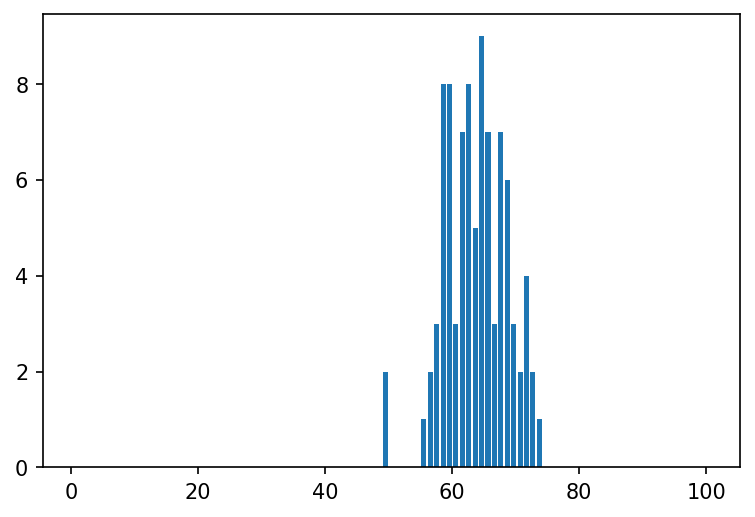

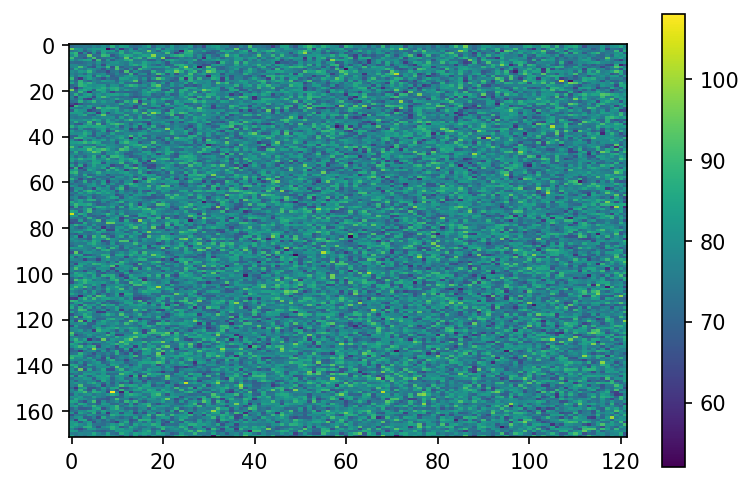

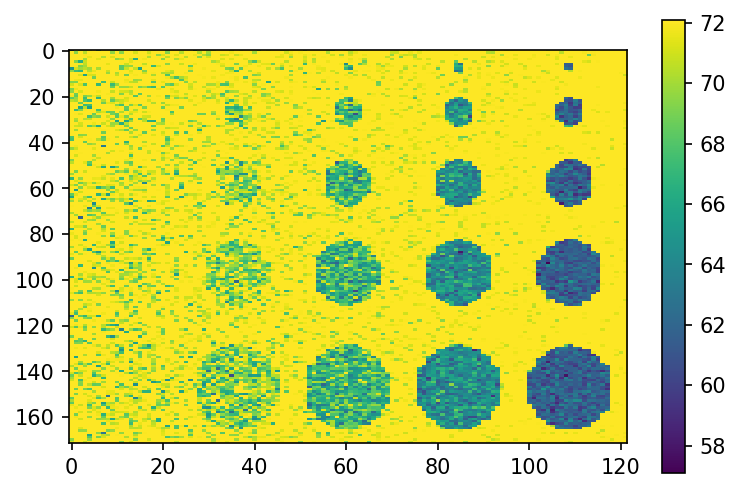

In [25]:
bins = 100#The number of bins. Only a subset is used to improve computation speed

num_frames = 100#The number of frames in a batch. Batch processing is used to reduce memory requirements.

target_frame_num = 1000#The final total number of frames required

pix_x = 122#The final number of pixels in x
pix_y = 172#The final number of pixels in y

total_pix = pix_x*pix_y

histo_frames = np.zeros((pix_y,pix_x,target_frame_num))#Pre allocating click array

jitter = 220e-12#inter-pulse jitter

f_num = 2.0#lens f_num

pixel_jit_map_max = 1.0e-9# maximum inter-frame inter-pixel column wise jitter
pixel_jit_map_min = pixel_jit_map_max/4.0 # minimum inter-frame inter-pixel column wise jitter

pixel_jit_sig = np.linspace(pixel_jit_map_min/6.0,pixel_jit_map_max/6.0,pix_x)#An  inter-frame inter-pixel jitter vector varying linearly across the SPAD

pixel_jit_map = np.zeros((pix_y,pix_x))#Pre allocating the inter-frame inter-pixel jitter array

for i in tqdm(range(0,pix_x)):
    pixel_jit_map[:,i] = np.random.normal(0.0,pixel_jit_sig[i],pix_y)# populating each column of the inter-frame inter-pixel jitter array
    
pixel_jit_map = np.fliplr(pixel_jit_map)# Reversing jitter map to match experiments

for i in tqdm(range(0,pix_x)):
    for j in range(0,pix_y):

        for k in range(0,int(target_frame_num/num_frames)):
            
            histo_frames[j,i,k*num_frames:(k*num_frames)+num_frames] = make_clicks(bins,cp.asarray(peak_pos_2[j,i]+pixel_jit_map[j,i]),jitter,0.08956,0.08956,num_frames,f_num)#Performing the sampling
        
        




histograms = np.zeros((pix_y,pix_x,bins))#Pre allocating the array

for i in tqdm(range(0,pix_x)):
    for j in range(0,pix_y):
        histograms[j,i,:] , ig1 = np.histogram(histo_frames[j,i,:],bins=np.linspace(0,bins,bins+1))#Processing the clicks matrix into histograms for each pixel
        

#Visulizaing the histogram for a single pixel
plt.bar(np.linspace(1,bins,bins-1),histograms[0,0,1:])
plt.show()  

#Visulizing the SPC image
plt.imshow(np.sum(histograms[:,:,1:],axis=2),interpolation='none', aspect='0.5')
plt.colorbar()
plt.show()

#Calculate the centre of mass for each pixel from the histograms
coms = calc_CoM(histograms[:,:,1:],bins,50e-12)

#Visulize the depth image
plt.imshow(coms[:,:],vmin = np.amin(coms[:,:]),vmax = np.amin(coms[:,:])+15,interpolation='none', aspect='0.5')
plt.colorbar()
plt.show()  

 

In [12]:
def calc_CoM(histo,bins,t_res):
    #A centre of mass function to convert histograms to depth for visulization/debuging only. Formal histogram -> depth conversion must be performed by match filtering  
    r = histo.shape[0]
    c = histo.shape[1]

    t_vec = np.linspace(1,bins-1,bins-1)

    CoM = np.zeros((r,c))
    #For each pixel in the image
    for i in range(0,r):
        for j in range(0,c):
            if np.sum(histo[i,j,:],axis=0) >0:# check to avoid division by 0 errors in empty pixels.
                CoM[i,j] = np.sum(histo[i,j,:]*t_vec)/np.sum(histo[i,j,:],axis=0)#Calculation of centre of mass
                

    return CoM


In [23]:
def make_clicks(bins,peak_posi,jitter,C_ref,bckg_refs,num_frames,f_num):
    #This function returns an array of sensor clicks which can then be processed into a histogram
    

    fps = 1000#The cameras operational frame rate

    exp_time = 1/fps#The exposure time

    rep_rate = 2.25e6#The repition rate of the laser

    energy_per_pulse = 1.219e-9#The pulse energy of the laser

    pulse_width_fwhm = 0.6e-9#The pulse width of the laser

    t_res = 50e-12#The temproal resolution of the SPAD

    num_pulses = int(cp.round(exp_time*rep_rate))#The number of pulses in a frame
    
    spad_q_base_efficiency = 0.18#The effective quantum efficiency of the SPAD

    spad_q_efficiency = spad_q_base_efficiency
        
    target_range = 14.73#The range to the target

    fibre_core = 550e-6#The size of the fibre core used for illumination
    illum_lens = 8e-3#The focal length of the illuminating lens

    illum_radius = ((target_range/illum_lens)*fibre_core)/2.0#The radius of the illuminated area

    effictive_pix_size_x = 9.2e-6#The effective size of the pixels including fill factor
    effictive_pix_size_y = 9.2e-6#The effective size of the pixels including fill factor

    f_no = f_num#The f number of the lens

    dark_count_rate = 126# specific to our sensor
    solar_background_per_meter = 0.0# Set to zero since the experiment was conducted indoors

    sig_photon,solar_background_off_of_target_photon = calc_liklyhood(num_frames,C_ref,bckg_refs,bins,exp_time,rep_rate,energy_per_pulse,peak_posi,pulse_width_fwhm,spad_q_efficiency,t_res,target_range,illum_radius,effictive_pix_size_x,effictive_pix_size_y,f_no,dark_count_rate,solar_background_per_meter)#The average number of signal and background photons measured by the sensor per pulse

    all_clicks = calc_all_clicks(peak_posi,jitter,num_pulses,bins,t_res,solar_background_off_of_target_photon,dark_count_rate,sig_photon,pulse_width_fwhm,num_frames)#Photon measurements from the SPAD which can be processed into histograms

    return all_clicks




In [22]:
def calc_liklyhood(num_frames,C_ref,bckg_refs,bins,exp_time,rep_rate,energy_per_pulse,peak_posi,pulse_width_fwhm,spad_q_efficiency,t_res,target_range,illum_radius,effictive_pix_size_x,effictive_pix_size_y,f_no,dark_count_rate,solar_background_per_meter):
    
    #This function calculates the number of photons per pulse.

    illum_area = cp.pi*(illum_radius)**2#The area illuminated by the laser

    C_atm = (10**(-1*(7e-4/10.0)))#The transmission coefficent of the atmosphere

    wavelength = 671e-9 #Wavelength of pulse laser

    c_speed = 2.99e8 #speed of light
    plank = 6.626e-34 #Planks constant

    sig_photon = ((wavelength*energy_per_pulse)/(plank*c_speed))*((spad_q_efficiency*C_ref*(C_atm**(2*target_range)))/(8*((f_no**2))))*((effictive_pix_size_x*effictive_pix_size_y)/(illum_area))#The average number of photons measured by the detector per laser pulse

    dark_counts = dark_count_rate #The dark count rate of the detector

    solar_background_off_of_target_photon = ((wavelength*solar_background_per_meter)/(plank*c_speed))*((spad_q_efficiency*bckg_refs*(C_atm**(target_range)))/(8*((f_no**2))))*((effictive_pix_size_x*effictive_pix_size_y)/(illum_area))#The average number of solar background photons measured by the detector per laser pulse

    return sig_photon,solar_background_off_of_target_photon

In [21]:
def calc_all_clicks(peak_posi,jitter,num_pulses,bins,t_res,solar_background_off_of_target_photon,dark_counts,sig_photon,pulse_width_fwhm,num_frames):
    
    #This function performs the binomial sampling

    sigma = pulse_width_fwhm/(2*cp.sqrt(2*cp.log(2))) # The width of the laser pulse

    bins_lb = cp.linspace(0,bins-1,bins)*t_res #The lower bound of the histogram bins
    bins_ub = cp.linspace(1,bins,bins)*t_res #The upper bound of the histogram bins

    bins_lb = cp.tile(bins_lb,[num_pulses,num_frames,1]) #This tiles the lower bound vector up to a matrix
    bins_lb = cp.moveaxis(bins_lb,[0,1,2],[0,2,1])# Reordering the indices 

    bins_ub = cp.tile(bins_ub,[num_pulses,num_frames,1])  #This tiles the upper bound vector up to a matrix
    bins_ub = cp.moveaxis(bins_ub,[0,1,2],[0,2,1])# Reordering the indices 

    jit = (cp.random.rand(num_pulses,num_frames))*jitter #A matrix of jitter values reflecting the jitter between pulses within a single frame

    jit = cp.tile(jit,[bins,1,1])# tiling the jitter matrix to match the dimensions of the bin limits

    jit = cp.moveaxis(jit,[0,1,2],[1,0,2])# Reordering the indices 

    
    bino_prob = cp.fmin((((solar_background_off_of_target_photon+dark_counts)*t_res) + (sig_photon/2)*(cpx.scipy.special.erf((peak_posi+jit-bins_lb)/(sigma*cp.sqrt(2))) - cpx.scipy.special.erf((peak_posi+jit-bins_ub)/(sigma*cp.sqrt(2))))),1.0)#The discretized histogram photon probobility matrix

    trials = cp.ones((num_pulses,bins,num_frames),dtype=int)# An array of ones each representing a potential photon measurement

    n0 = cp.random.binomial(trials,bino_prob,dtype=cp.float32)# The binomial sampling procedure
    
    n0 = cp.minimum(n0,1)# Restricting the sampling to single photons
    
    clicks = first_nonzero(n0, axis=1, invalid_val=0)#This limits the photons detection to one photon per pulse

    clicks_2 = np.squeeze(np.copy(cp.asnumpy(cp.take_along_axis(clicks, cp.squeeze(first_nonzero(clicks, axis=0, invalid_val=0))[None,:], axis=0))))#The limits the photons detection to one photon per frame

    return clicks_2
    
    #Deleting these variables prevents memeory leaks during loop operations
    del n0
    del trials
    del ig1
    del sig_photon
    del clicks
    del clicks_2


In [8]:
def first_nonzero(arr, axis, invalid_val=-1):
    #This function returns the input with all but the first non-zero element along an axis set to zero
    mask = arr!=0
    return np.where(mask.any(axis=axis), mask.argmax(axis=axis), invalid_val)